In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score,f1_score
import warnings
import time
import category_encoders as ce
from  datetime import datetime, timedelta
pd.set_option('display.max_colwidth',200)
import os
warnings.filterwarnings('ignore')
path='../data/zhao2/'#新数据目录
#path2='../data/zhao/'#旧数据不用

In [2]:
os.listdir(path)

['val_tag.csv',
 'val_trd.csv',
 'train_tag.csv',
 'train_trd.csv',
 'val_beh.csv',
 'train_beh.csv',
 'val_tag_b.csv',
 'val_beh_b.csv',
 'val_trd_b.csv']

#### 换上B榜测试集，名字没改沿用A榜的

In [3]:
#val_tag_a = pd.read_csv(path+'val_tag.csv')
#val_beh_a = pd.read_csv(path+'val_beh.csv')
#val_trd_a = pd.read_csv(path+'val_trd.csv')
train_tag = pd.read_csv(path+'train_tag.csv')
train_beh = pd.read_csv(path+'train_beh.csv')
train_trd = pd.read_csv(path+'train_trd.csv')
val_tag_a = pd.read_csv(path+'val_tag_b.csv')
val_beh_a = pd.read_csv(path+'val_beh_b.csv')
val_trd_a = pd.read_csv(path+'val_trd_b.csv')

In [4]:
len(set(val_beh_a.id))

1232

In [5]:
len(set(train_beh.id))

11913

In [6]:
del train_trd['flag']
del train_beh['flag']
val_tag_a['flag']=3
trd=pd.concat((train_trd, val_trd_a)).reset_index(drop=True)
beh=pd.concat((train_beh, val_beh_a)).reset_index(drop=True)
tag=pd.concat((train_tag, val_tag_a)).reset_index(drop=True)

In [7]:
len(set(beh.id))

13145

In [8]:
tag[tag.id.isin(set(beh.id))].shape

(13145, 43)

In [9]:
trd.select_dtypes(include='object').columns

Index(['id', 'Dat_Flg1_Cd', 'Dat_Flg3_Cd', 'trx_tm'], dtype='object')

# tag基础信息

### 1.根据eda填充具体的缺失值

In [10]:
tag.loc[tag.confirm_rsk_ases_lvl_typ_cd=='\\N','confirm_rsk_ases_lvl_typ_cd']=7#
tag['confirm_rsk_ases_lvl_typ_cd']=tag['confirm_rsk_ases_lvl_typ_cd'].astype(int)
tag.loc[tag.crd_card_act_ind=='\\N','crd_card_act_ind']=1#3+  0~1,1
tag['crd_card_act_ind']=tag['crd_card_act_ind'].astype(int)
tag.loc[tag.cust_inv_rsk_endu_lvl_cd=='\\N','cust_inv_rsk_endu_lvl_cd']=10#10+  1~9,7
tag['cust_inv_rsk_endu_lvl_cd']=tag['cust_inv_rsk_endu_lvl_cd'].astype(int)
tag.loc[tag.dnl_bind_cmb_lif_ind=='\\N','dnl_bind_cmb_lif_ind']=1#2+  0~1,1
tag['dnl_bind_cmb_lif_ind']=tag['dnl_bind_cmb_lif_ind'].astype(int)
tag.loc[tag.dnl_mbl_bnk_ind=='\\N','dnl_mbl_bnk_ind']=1#2+  0~1,1
tag['dnl_mbl_bnk_ind']=tag['dnl_mbl_bnk_ind'].astype(int)
tag.loc[tag.fin_rsk_ases_grd_cd=='\\N','fin_rsk_ases_grd_cd']=10#
tag['fin_rsk_ases_grd_cd']=tag['fin_rsk_ases_grd_cd'].astype(int)
tag.loc[tag.fr_or_sh_ind=='\\N','fr_or_sh_ind']=1#2+  0~1,1
tag['fr_or_sh_ind']=tag['fr_or_sh_ind'].astype(int)
tag.loc[tag.frs_agn_dt_cnt=='\\N','frs_agn_dt_cnt']=7#day+  ==
tag['frs_agn_dt_cnt']=tag['frs_agn_dt_cnt'].astype(int)
tag.loc[tag.hav_car_grp_ind=='\\N','hav_car_grp_ind']=0#2+  0~1,0
tag['hav_car_grp_ind']=tag['hav_car_grp_ind'].astype(int)
tag.loc[tag.hav_hou_grp_ind=='\\N','hav_hou_grp_ind']=1#2+  0~1,1
tag['hav_hou_grp_ind']=tag['hav_hou_grp_ind'].astype(int)
tag.loc[tag.his_lng_ovd_day=='\\N','his_lng_ovd_day']=18#day+  ==
tag['his_lng_ovd_day']=tag['his_lng_ovd_day'].astype(int)
tag.loc[tag.hld_crd_card_grd_cd=='\\N','hld_crd_card_grd_cd']=20#++  ,20
tag['hld_crd_card_grd_cd']=tag['hld_crd_card_grd_cd'].astype(int)
tag.loc[tag.ic_ind=='\\N','ic_ind']=1#2+  0~1,1
tag['ic_ind']=tag['ic_ind'].astype(int)
tag.loc[tag.job_year=='\\N','job_year']=14#year+  ==
tag['job_year']=tag['job_year'].astype(int)
tag.loc[tag.l12_mon_fnd_buy_whl_tms=='\\N','l12_mon_fnd_buy_whl_tms']=53#count+  ==
tag['l12_mon_fnd_buy_whl_tms']=tag['l12_mon_fnd_buy_whl_tms'].astype(int)
tag.loc[tag.l12_mon_gld_buy_whl_tms=='\\N','l12_mon_gld_buy_whl_tms']=5#count+  ==
tag['l12_mon_gld_buy_whl_tms']=tag['l12_mon_gld_buy_whl_tms'].astype(int)
tag.loc[tag.l12_mon_insu_buy_whl_tms=='\\N','l12_mon_insu_buy_whl_tms']=6#count+  ==
tag['l12_mon_insu_buy_whl_tms']=tag['l12_mon_insu_buy_whl_tms'].astype(int)
tag.loc[tag.l12mon_buy_fin_mng_whl_tms=='\\N','l12mon_buy_fin_mng_whl_tms']=50#count+  ==
tag['l12mon_buy_fin_mng_whl_tms']=tag['l12mon_buy_fin_mng_whl_tms'].astype(int)
tag.loc[tag.l1y_crd_card_csm_amt_dlm_cd=='\\N','l1y_crd_card_csm_amt_dlm_cd']=0#6+  0~5,0
tag['l1y_crd_card_csm_amt_dlm_cd']=tag['l1y_crd_card_csm_amt_dlm_cd'].astype(int)
tag.loc[tag.l6mon_agn_ind=='\\N','l6mon_agn_ind']=1#2+  0~1,1
tag['l6mon_agn_ind']=tag['l6mon_agn_ind'].astype(int)
tag.loc[tag.loan_act_ind=='\\N','loan_act_ind']=1#2+  0~1,1
tag['loan_act_ind']=tag['loan_act_ind'].astype(int)
tag.loc[tag.ovd_30d_loan_tot_cnt=='\\N','ovd_30d_loan_tot_cnt']=1#day+  ==
tag['ovd_30d_loan_tot_cnt']=tag['ovd_30d_loan_tot_cnt'].astype(int)
tag.loc[tag.pot_ast_lvl_cd=='\\N','pot_ast_lvl_cd']=2#7+  -1~6,2
tag['pot_ast_lvl_cd']=tag['pot_ast_lvl_cd'].astype(int)
tag.loc[tag.tot_ast_lvl_cd=='\\N','tot_ast_lvl_cd']=3#7+  -1~12,3
tag['tot_ast_lvl_cd']=tag['tot_ast_lvl_cd'].astype(int)
tag.loc[tag.vld_rsk_ases_ind=='\\N','vld_rsk_ases_ind']=1#2+  0~1,1
tag['vld_rsk_ases_ind']=tag['vld_rsk_ases_ind'].astype(int)


tag.loc[tag.acdm_deg_cd=='\\N','acdm_deg_cd']='30'
tag['acdm_deg_cd']=tag['acdm_deg_cd'].fillna('30')

tag.loc[tag.atdd_type=='\\N','atdd_type']=2
tag['atdd_type']=tag['atdd_type'].fillna(2)
tag['atdd_type']=tag['atdd_type'].astype(int)

tag.loc[tag.deg_cd=='\\N','deg_cd']='E'
tag['deg_cd']=tag['deg_cd'].fillna('K')

tag.loc[tag.edu_deg_cd=='\\N','edu_deg_cd']='O'
tag['edu_deg_cd']=tag['edu_deg_cd'].fillna('N')

#tag.loc[tag['cur_credit_min_opn_dt_cnt'] == -1,'cur_credit_min_opn_dt_cnt'] = 4595
#tag.loc[tag['cur_debit_min_opn_dt_cnt'] == -1,'cur_debit_min_opn_dt_cnt'] = 2077   
#年龄分箱
tag['age_range'] = pd.cut(tag['age'], [0, 19, 29, 39, 49, 59, 100], labels=False)

### 2.类别编码

In [11]:
tag.select_dtypes(include='object').columns

Index(['id', 'gdr_cd', 'mrg_situ_cd', 'edu_deg_cd', 'acdm_deg_cd', 'deg_cd'], dtype='object')

In [12]:
le = LabelEncoder()#仅仅变成数字  
for i in ['acdm_deg_cd', 'deg_cd', 'edu_deg_cd', 'gdr_cd', 'mrg_situ_cd']:    
    tag[i] = le.fit_transform(tag[i])

In [13]:
tag.select_dtypes(include='object').columns

Index(['id'], dtype='object')

# trd交易数据

### 1.日期数据转换

In [14]:
trd["trx_tm"] = pd.to_datetime(trd["trx_tm"])
trd['Week']=trd['trx_tm'].apply(lambda x:int(x.strftime('%U')))
date_features = {
        "wday": "weekday",
        "month": "month",
        "mday": "day",
    }
for date_feat_name, date_feat_func in date_features.items(): 
    trd[date_feat_name] = getattr(trd["trx_tm"].dt, date_feat_func).astype("int16")
trd['nday']=trd["trx_tm"]-trd.trx_tm.min()
trd['nday']=trd['nday'].apply(lambda x:int(str(x)[:2]))

In [15]:
trd.head()

,id,Dat_Flg1_Cd,Dat_Flg3_Cd,Trx_Cod1_Cd,Trx_Cod2_Cd,trx_tm,cny_trx_amt,Week,wday,month,mday,nday
0,UFDC88A,B,B,1,116,2019-06-20 07:15:28,-127.99,24,3,6,20,50
1,UFDC88A,B,B,1,116,2019-06-16 10:09:13,-55.88,24,6,6,16,46
2,UFDC88A,B,B,1,136,2019-05-14 16:11:32,-557.00,19,1,5,14,13
3,UFDC88A,B,B,1,136,2019-05-19 21:54:40,-77.80,20,6,5,19,18
4,UFDC88A,B,B,1,113,2019-06-18 08:23:59,-271.62,24,1,6,18,48


### 2.用户借还金额特征

In [16]:
trd['Dat_Flg1_Flg3_Cd']=trd['Dat_Flg1_Cd']+trd['Dat_Flg3_Cd']
trd['Dat_Flg3_Cod1_Cd']=trd['Dat_Flg3_Cd']+trd['Trx_Cod1_Cd'].astype(str)
trd['Dat_Flg1_Cod1_Cd']=trd['Dat_Flg1_Cd']+trd['Trx_Cod1_Cd'].astype(str)

trd['Dat_Flg1_Week']=trd['Dat_Flg1_Cd']+trd['Week'].astype(str)
trd['Dat_Flg1_wday']=trd['Dat_Flg1_Cd']+trd['wday'].astype(str)
trd['Dat_Flg1_month']=trd['Dat_Flg1_Cd']+trd['month'].astype(str)

#trd['Dat_Flg1_Flg3_Cod1_Cd']=trd['Dat_Flg1_Cd']+trd['Dat_Flg3_Cd']+trd['Trx_Cod1_Cd'].astype(str)
trd_=pd.DataFrame()
trd_['id']=pd.Series(list(set(trd.id)))

#,'Cod2':'Trx_Cod2_Cd'
all={'Flg1':'Dat_Flg1_Cd','Flg3':'Dat_Flg3_Cd','Cod1':'Trx_Cod1_Cd','Cod2':'Trx_Cod2_Cd','Week':'Week','wday':'wday','month':'month',
    'Flg1Flg3':'Dat_Flg1_Flg3_Cd','Flg3Cod1':'Dat_Flg3_Cod1_Cd','Flg1Cod1':'Dat_Flg1_Cod1_Cd',
     'Flg1Week':'Dat_Flg1_Week','Flg1wday':'Dat_Flg1_wday','Flg1month':'Dat_Flg1_month'}
for col,v in all.items():
    temp=trd.groupby(['id',v],as_index=False)['cny_trx_amt'].agg({
            col+'_min':'min',
            col+'_max':'max',
            col+'_sum':'sum',
            col+'_mean':'mean',
            col+'_count':'count',
            col+'_median':'median',
            col+'_std':'std'
        })
    
    temp=temp.set_index(['id',v])
    temp=temp.unstack()
    lam=sorted(list(set(trd[v])))
    trd_col=[]
    for y in [col+'_min',col+'_max',col+'_sum',col+'_mean',col+'_count',col+'_median',col+'_std']:
        trd_col+=(list(map(lambda x:y+'_'+str(x),lam)))
    temp.columns = trd_col
    temp.reset_index(inplace=True) 
    trd_=pd.merge(trd_,temp,on='id',how='left')      
trd_.fillna(0., inplace = True)

### 3.用户每天的还借次数统计-------按借还款

In [18]:
trd_count=trd[['id','Dat_Flg1_Cd','trx_tm','nday','cny_trx_amt']].copy()
temp=trd_count.groupby(['id','Dat_Flg1_Cd','nday'],as_index=False)['cny_trx_amt'].agg({'day_Flg1_count': 'count'})
v='Dat_Flg1_Cd'
col='day_Flg1_count'
temp=temp.groupby(['id',v],as_index=False)['day_Flg1_count'].agg({
            col+'_min':'min',
            col+'_max':'max',
            col+'_sum':'sum',
            col+'_mean':'mean'
        })
temp=temp.set_index(['id',v])
temp=temp.unstack()
lam=sorted(list(set(trd[v])))
trd_col=[]
for y in [col+'_min',col+'_max',col+'_sum',col+'_mean']:
    trd_col+=(list(map(lambda x:y+'_'+str(x),lam)))
temp.columns = trd_col
temp.reset_index(inplace=True) 
trd_=pd.merge(trd_,temp,on='id',how='left')
trd_.fillna(0., inplace = True)    

### 4.用户活跃天数-------按借还款

In [19]:
col='Flg1_days'
v='Dat_Flg1_Cd'
temp=trd_count.groupby(['id',v],as_index=False)['nday'].agg({'Flg1_days': 'count'})
temp=temp.set_index(['id',v])
temp=temp.unstack()
lam=sorted(list(set(trd[v])))
trd_col=(list(map(lambda x:col+'_'+str(x),lam)))
temp.columns = trd_col
temp.reset_index(inplace=True) 
trd_=pd.merge(trd_,temp,on='id',how='left')
trd_.fillna(0., inplace = True)  

In [20]:
data=pd.merge(tag,trd_,on='id',how='left')

In [21]:
data.fillna(0., inplace = True)
data.isnull().sum()

id                       0
flag                     0
gdr_cd                   0
age                      0
mrg_situ_cd              0
                        ..
day_Flg1_count_sum_C     0
day_Flg1_count_mean_B    0
day_Flg1_count_mean_C    0
Flg1_days_B              0
Flg1_days_C              0
Length: 1041, dtype: int64

In [22]:
data.shape

(43923, 1041)

# 划分训练测试集，验证集随机采样20%，避免本地线下分数过高

In [23]:
df_test = data[data['flag']==3].copy()
df_train = data[data['flag']!=3].copy()

In [25]:
# y_vaild与测试集长不多用的全部train的交叉 
#否则请跳过这一步
df_train=df_train.sample(frac=1.0)
df_train = df_train.reset_index()
del df_train['index']
vaild = df_train.loc[31923:39922,]
df_train = df_train.loc[0:31923,]

## 1.构造新特征

In [26]:
from sklearn.model_selection import KFold, StratifiedKFold
N_SPLITS = 5
SEED = 100

folds = KFold(n_splits=N_SPLITS,shuffle = False, random_state=SEED)
#['cur_debit_cnt','age','job_year','frs_agn_dt_cnt','l12mon_buy_fin_mng_whl_tms','l12_mon_fnd_buy_whl_tms','l12_mon_insu_buy_whl_tms','l12_mon_gld_buy_whl_tms','his_lng_ovd_day']
#['ovd_30d_loan_tot_cnt']
#'cur_credit_min_opn_dt_cnt_range','cur_debit_min_opn_dt_cnt_range',
target_mean_list =['cur_credit_cnt','cur_debit_crd_lvl','hld_crd_card_grd_cd','crd_card_act_ind','l1y_crd_card_csm_amt_dlm_cd','atdd_type','perm_crd_lmt_cd','gdr_cd','mrg_situ_cd','edu_deg_cd','acdm_deg_cd','deg_cd','ic_ind','fr_or_sh_ind','dnl_mbl_bnk_ind','dnl_bind_cmb_lif_ind','hav_car_grp_ind','hav_hou_grp_ind','l6mon_agn_ind','vld_rsk_ases_ind','fin_rsk_ases_grd_cd','confirm_rsk_ases_lvl_typ_cd','cust_inv_rsk_endu_lvl_cd','l6mon_daim_aum_cd','tot_ast_lvl_cd','pot_ast_lvl_cd','bk1_cur_year_mon_avg_agn_amt_cd','loan_act_ind','pl_crd_lmt_cd']
#for col in target_mean_list:
#    df_train[col+'_target']=np.NAN
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    print('Fold:',fold_+1)
    tr_x = df_train.iloc[trn_idx,:] 
    vl_x = df_train.iloc[val_idx,:]  

    for col in target_mean_list:
        temp=tr_x.groupby([col],as_index=False)['flag'].agg({col+'_sum':'sum',col+'_count':'count'})
        temp[col+'_target']=temp[col+'_sum']/temp[col+'_count']
        df_train.loc[val_idx,col+'_target']=list(pd.merge(df_train.loc[val_idx,col],temp[[col,col+'_target']],on=col,how='left')[col+'_target'])
        
# y_vaild与测试集长不多用的全部train的交叉 20200502 23:58:00
for col in target_mean_list:
    temp=df_train.groupby([col],as_index=False)['flag'].agg({col+'_sum':'sum',col+'_count':'count'})
    temp[col+'_target']=temp[col+'_sum']/temp[col+'_count']
    vaild[col+'_target'] = list(pd.merge(vaild[col],temp[[col,col+'_target']],on=col,how='left')[col+'_target'])

for col in target_mean_list:
    temp=df_train.groupby([col],as_index=False)['flag'].agg({col+'_sum':'sum',col+'_count':'count'})
    temp[col+'_target']=temp[col+'_sum']/temp[col+'_count']
    df_test[col+'_target'] = list(pd.merge(df_test[col],temp[[col,col+'_target']],on=col,how='left')[col+'_target'])


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5


In [27]:
df_train.shape

(31924, 1070)

In [28]:
y_train = df_train.pop('flag')
feature = list(filter(lambda x: x not in ['flag','id','index'], df_train.columns))
X_train = df_train[feature]
X_valid = vaild[feature]
y_valid = vaild.pop('flag')

In [29]:
X_train.shape

(31924, 1068)

## 2.舍弃目标编码，对类别特征进行WOEEncoder编码

In [30]:
oof = pd.DataFrame([])
target_mean_list =['cur_credit_cnt','cur_debit_crd_lvl','hld_crd_card_grd_cd','crd_card_act_ind','l1y_crd_card_csm_amt_dlm_cd','atdd_type','perm_crd_lmt_cd','gdr_cd','mrg_situ_cd','edu_deg_cd','acdm_deg_cd','deg_cd','ic_ind','fr_or_sh_ind','dnl_mbl_bnk_ind','dnl_bind_cmb_lif_ind','hav_car_grp_ind','hav_hou_grp_ind','l6mon_agn_ind','vld_rsk_ases_ind','fin_rsk_ases_grd_cd','confirm_rsk_ases_lvl_typ_cd','cust_inv_rsk_endu_lvl_cd','l6mon_daim_aum_cd','tot_ast_lvl_cd','pot_ast_lvl_cd','bk1_cur_year_mon_avg_agn_amt_cd','loan_act_ind','pl_crd_lmt_cd']
target_mean_list2=[]
#oof['age_range_WOE']=np.NAN
from sklearn.model_selection import StratifiedKFold
for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=2020, shuffle=True).split(X_train, y_train):
    #for col in target_mean_list2:
    woe_encoder = ce.WOEEncoder(cols = target_mean_list)
    woe_encoder.fit(X_train.loc[tr_idx, target_mean_list], y_train.loc[tr_idx])
    oof = oof.append(woe_encoder.transform(X_train.loc[oof_idx, target_mean_list]), ignore_index=False)
for i in target_mean_list:
    target_mean_list2.append(i+'_woe')
oof.columns=target_mean_list2
X_train=X_train.join(oof) 

woe_encoder = ce.WOEEncoder(cols = target_mean_list)
woe_encoder.fit(X_train[target_mean_list], y_train);
valid_oof = woe_encoder.transform(X_valid[target_mean_list])
valid_oof.columns=target_mean_list2
X_valid=X_valid.join(valid_oof)

test_oof = woe_encoder.transform(df_test[target_mean_list])
test_oof.columns=target_mean_list2
df_test=df_test.join(test_oof)

In [31]:
X_train.shape

(31924, 1097)

## 20200512临时构造的特征并做了WOEEncoder编码（发现拥有卡天数特征比较重要，并加上一些交叉特征）

In [35]:
X_train['cur_credit_min_opn_dt_cnt_range'] = pd.cut(X_train['cur_credit_min_opn_dt_cnt'], [-2, 0, 180, 360, 720, 1080,1440,1800,2160,2520,2880,3240,3600,3960,4320,4680,5040,5400,5760,6120 ], labels=False)
X_train['cur_debit_min_opn_dt_cnt_range'] = pd.cut(X_train['cur_debit_min_opn_dt_cnt'], [-2, 0, 180, 360, 720, 1080,1440,1800,2160,2520,2880,3240,3600,3960,4320,4680,5040,5400,5760,6120,6480,6840,7200,7560,7920,8280,10000], labels=False)

X_valid['cur_credit_min_opn_dt_cnt_range'] = pd.cut(X_valid['cur_credit_min_opn_dt_cnt'], [-2, 0, 180, 360, 720, 1080,1440,1800,2160,2520,2880,3240,3600,3960,4320,4680,5040,5400,5760,6120 ], labels=False)
X_valid['cur_debit_min_opn_dt_cnt_range'] = pd.cut(X_valid['cur_debit_min_opn_dt_cnt'], [-2, 0, 180, 360, 720, 1080,1440,1800,2160,2520,2880,3240,3600,3960,4320,4680,5040,5400,5760,6120,6480,6840,7200,7560,7920,8280,10000], labels=False)

df_test['cur_credit_min_opn_dt_cnt_range'] = pd.cut(df_test['cur_credit_min_opn_dt_cnt'], [-2, 0, 180, 360, 720, 1080,1440,1800,2160,2520,2880,3240,3600,3960,4320,4680,5040,5400,5760,6120 ], labels=False)
df_test['cur_debit_min_opn_dt_cnt_range'] = pd.cut(df_test['cur_debit_min_opn_dt_cnt'], [-2, 0, 180, 360, 720, 1080,1440,1800,2160,2520,2880,3240,3600,3960,4320,4680,5040,5400,5760,6120,6480,6840,7200,7560,7920,8280,10000], labels=False)

X_train['gdr_cd_age_range']=X_train['gdr_cd'].astype(str)+'_'+X_train['age_range'].astype(str)
X_train['gdr_cd_acdm']=X_train['acdm_deg_cd'].astype(str)+'_'+X_train['gdr_cd'].astype(str)
X_train['age_range_acdm']=X_train['acdm_deg_cd'].astype(str)+'_'+X_train['age_range'].astype(str)
X_train['acdm_gdr_cd_age_range']=X_train['acdm_deg_cd'].astype(str)+'_'+X_train['gdr_cd'].astype(str)+'_'+X_train['age_range'].astype(str)

X_valid['gdr_cd_age_range']=X_valid['gdr_cd'].astype(str)+'_'+X_valid['age_range'].astype(str)
X_valid['gdr_cd_acdm']=X_valid['acdm_deg_cd'].astype(str)+'_'+X_valid['gdr_cd'].astype(str)
X_valid['age_range_acdm']=X_valid['acdm_deg_cd'].astype(str)+'_'+X_valid['age_range'].astype(str)
X_valid['acdm_gdr_cd_age_range']=X_valid['acdm_deg_cd'].astype(str)+'_'+X_valid['gdr_cd'].astype(str)+'_'+X_valid['age_range'].astype(str)

df_test['gdr_cd_age_range']=df_test['gdr_cd'].astype(str)+'_'+df_test['age_range'].astype(str)
df_test['gdr_cd_acdm']=df_test['acdm_deg_cd'].astype(str)+'_'+df_test['gdr_cd'].astype(str)
df_test['age_range_acdm']=df_test['acdm_deg_cd'].astype(str)+'_'+df_test['age_range'].astype(str)
df_test['acdm_gdr_cd_age_range']=df_test['acdm_deg_cd'].astype(str)+'_'+df_test['gdr_cd'].astype(str)+'_'+df_test['age_range'].astype(str)

oof = pd.DataFrame([])
target_mean_list =['cur_credit_min_opn_dt_cnt_range','cur_debit_min_opn_dt_cnt_range','gdr_cd_age_range','gdr_cd_acdm','age_range_acdm','acdm_gdr_cd_age_range']
target_mean_list2=[]
#oof['age_range_WOE']=np.NAN
from sklearn.model_selection import StratifiedKFold
for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=2020, shuffle=False).split(X_train, y_train):
    #for col in target_mean_list2:
    woe_encoder = ce.WOEEncoder(cols = target_mean_list)
    woe_encoder.fit(X_train.loc[tr_idx, target_mean_list], y_train.loc[tr_idx])
    oof = oof.append(woe_encoder.transform(X_train.loc[oof_idx, target_mean_list]), ignore_index=False)
for i in target_mean_list:
    target_mean_list2.append(i+'_woe')
oof.columns=target_mean_list2

X_train=X_train.join(oof) 

woe_encoder = ce.WOEEncoder(cols = target_mean_list)
woe_encoder.fit(X_train[target_mean_list], y_train);
valid_oof = woe_encoder.transform(X_valid[target_mean_list])
valid_oof.columns=target_mean_list2
X_valid=X_valid.join(valid_oof)

test_oof = woe_encoder.transform(df_test[target_mean_list])
test_oof.columns=target_mean_list2
df_test=df_test.join(test_oof)

for i in target_mean_list:
    del X_train[i]
    del X_valid[i]
    del df_test[i]

## lgb单模型线下分数0.7724651154341885 线上 0.78514

In [36]:
feature = list(filter(lambda x: x not in ['flag','id','index'], X_train.columns))
param = {
    'num_leaves':70,
    'objective':'binary',    
    'max_depth':-1,
    'reg_alpha':3,
    'reg_lambda':5,
    'colsample_bytree':0.77,
    'random_state':1000,
    'min_child_weight':4,
    'min_child_samples':10,
    'min_split_gain':0,
    'learning_rate':0.01,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.4,
    'lambda_l1': 0.7,
    'seed':2014,
    'metric': {'l2', 'auc'}}
submit_df = df_test[['id']]
X_submit = df_test[feature]
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_valid, label=y_valid)
lgbm = lgb.train(param,trn_data,valid_sets=[trn_data,val_data],num_boost_round = 20000 ,early_stopping_rounds=1000,verbose_eval=50)
y_submit = lgbm.predict(X_submit)
submit_df['Label'] = y_submit
y_pred=lgbm.predict(X_valid)
roc_auc_score(y_valid, y_pred) 

Training until validation scores don't improve for 1000 rounds
[50]	training's l2: 0.151188	training's auc: 0.794945	valid_1's l2: 0.153534	valid_1's auc: 0.761468
[100]	training's l2: 0.139568	training's auc: 0.810246	valid_1's l2: 0.144567	valid_1's auc: 0.764014
[150]	training's l2: 0.132728	training's auc: 0.82787	valid_1's l2: 0.140177	valid_1's auc: 0.765955
[200]	training's l2: 0.127934	training's auc: 0.845092	valid_1's l2: 0.137836	valid_1's auc: 0.767255
[250]	training's l2: 0.124157	training's auc: 0.859861	valid_1's l2: 0.136507	valid_1's auc: 0.768589
[300]	training's l2: 0.120875	training's auc: 0.872009	valid_1's l2: 0.135656	valid_1's auc: 0.770102
[350]	training's l2: 0.11784	training's auc: 0.883088	valid_1's l2: 0.13504	valid_1's auc: 0.77094
[400]	training's l2: 0.115032	training's auc: 0.89211	valid_1's l2: 0.134581	valid_1's auc: 0.772054
[450]	training's l2: 0.112387	training's auc: 0.899744	valid_1's l2: 0.13426	valid_1's auc: 0.772441
[500]	training's l2: 0.109

0.7724651154341885

<Figure size 1440x72000 with 0 Axes>

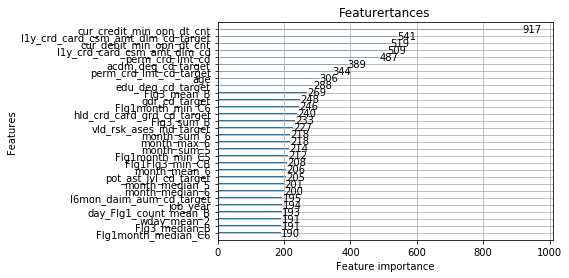

In [96]:
plt.figure(figsize=(20,1000))
lgb.plot_importance(lgbm, max_num_features=30)
plt.title("Featurertances")
plt.show()

In [53]:
t_str=time.strftime('%Y_%m%d_%H_%M',time.localtime(time.time()))     
submit_df.to_csv(f"submission_{t_str}.txt",sep='\t',index=False,header=0,encoding="utf_8")